In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv('../Data/train.csv')

train = train.drop("id", axis = 1)

defect_counts = train[["Pastry","Z_Scratch","K_Scatch","Stains","Dirtiness","Bumps","Other_Faults"]].sum(axis=1)
train = train[defect_counts==1]

train['target'] = train[["Pastry","Z_Scratch","K_Scatch","Stains","Dirtiness","Bumps","Other_Faults"]].apply(lambda row: row.idxmax(), axis=1)
train = train.drop(["Pastry","Z_Scratch","K_Scatch","Stains","Dirtiness","Bumps","Other_Faults"],axis = 1)

label_map = {'Pastry': 0, 'Z_Scratch': 1, 'K_Scatch': 2, 'Stains': 3, 'Dirtiness': 4, 'Bumps': 5, 'Other_Faults': 6}
train['target'] = train['target'].map(label_map)

In [4]:
train['TypeOfSteel'] = train.apply(lambda row: 0 if row['TypeOfSteel_A300'] == 1 else (1 if row['TypeOfSteel_A400'] == 1 else None), axis=1)
train = train.drop(["TypeOfSteel_A300", "TypeOfSteel_A400"], axis = 1)
train.dropna(inplace=True)

## XGB Based

In [15]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split



X = train.drop("target", axis = 1)
y = train["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = XGBClassifier(objective='multi:softmax')

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [16]:
y_score = model.predict_proba(X_train)
y_pred = model.predict(X_train)

In [17]:
from sklearn.metrics import roc_auc_score

micro_roc_auc_ovr = roc_auc_score(
    y_train,
    y_score,
    multi_class="ovr",
    average="macro",
)
micro_roc_auc_ovr

0.9962098707138752

In [18]:
from sklearn.metrics import f1_score

f1 = f1_score(
    y_train,
    y_pred,
    average='macro'  
)
f1

0.9575921288479297

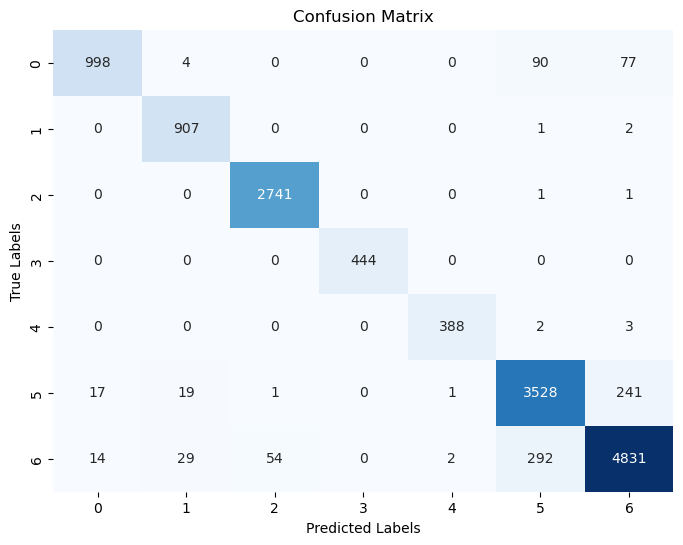

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_train)

conf_matrix = confusion_matrix(y_train, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [20]:
test = pd.read_csv("../Data/test.csv")

testid = test["id"]

test['TypeOfSteel'] = test.apply(lambda row: 0 if row['TypeOfSteel_A300'] == 1 else (1 if row['TypeOfSteel_A400'] == 1 else None), axis=1)
test = test.drop(["TypeOfSteel_A300", "TypeOfSteel_A400"], axis = 1)

test["TypeOfSteel"] = test["TypeOfSteel"].fillna(1)
testX = test.drop("id", axis = 1)

In [21]:
y_test_score = model.predict_proba(testX)

In [22]:
testPred = pd.DataFrame(y_test_score)
testPred.columns = ["Pastry","Z_Scratch","K_Scatch","Stains","Dirtiness","Bumps","Other_Faults"]
testPred

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0.475054,0.000243,0.000444,0.000010,0.019388,0.144825,0.360036
1,0.246959,0.001001,0.000725,0.000029,0.290379,0.072954,0.387953
2,0.000292,0.055409,0.026413,0.000058,0.000676,0.295432,0.621720
3,0.132627,0.000129,0.000091,0.000069,0.004056,0.409432,0.453596
4,0.000284,0.000316,0.000047,0.000129,0.001936,0.756886,0.240402
...,...,...,...,...,...,...,...
12809,0.084724,0.081736,0.000537,0.000039,0.005218,0.359784,0.467962
12810,0.122251,0.000778,0.014892,0.002225,0.146619,0.361788,0.351446
12811,0.000032,0.000078,0.965874,0.000016,0.000026,0.000182,0.033791
12812,0.514646,0.001706,0.005084,0.000014,0.028412,0.134100,0.316037


In [23]:
ffile = testPred
ffile["id"] = testid

last_column = ffile.iloc[:, -1]
ffile = ffile.iloc[:, :-1]
ffile = pd.concat([last_column, ffile], axis=1)
ffile

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.475054,0.000243,0.000444,0.000010,0.019388,0.144825,0.360036
1,19220,0.246959,0.001001,0.000725,0.000029,0.290379,0.072954,0.387953
2,19221,0.000292,0.055409,0.026413,0.000058,0.000676,0.295432,0.621720
3,19222,0.132627,0.000129,0.000091,0.000069,0.004056,0.409432,0.453596
4,19223,0.000284,0.000316,0.000047,0.000129,0.001936,0.756886,0.240402
...,...,...,...,...,...,...,...,...
12809,32028,0.084724,0.081736,0.000537,0.000039,0.005218,0.359784,0.467962
12810,32029,0.122251,0.000778,0.014892,0.002225,0.146619,0.361788,0.351446
12811,32030,0.000032,0.000078,0.965874,0.000016,0.000026,0.000182,0.033791
12812,32031,0.514646,0.001706,0.005084,0.000014,0.028412,0.134100,0.316037


In [24]:
ffile.to_csv('../Submissions/xgbBased.csv', index=False)

## LGBM Based

In [32]:
import lightgbm as lgb

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'multiclass',
    'num_class': 7
}


bst = lgb.train( params = params, train_set = train_data, valid_sets=[test_data])


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5176
[LightGBM] [Info] Number of data points in the train set: 14688, number of used features: 26
[LightGBM] [Info] Start training from score -2.530882
[LightGBM] [Info] Start training from score -2.781342
[LightGBM] [Info] Start training from score -1.677979
[LightGBM] [Info] Start training from score -3.498962
[LightGBM] [Info] Start training from score -3.620977
[LightGBM] [Info] Start training from score -1.350189
[LightGBM] [Info] Start training from score -1.034150


In [41]:
y_score = bst.predict(X_test)
y_pred = [list(x).index(max(x)) for x in y_score]


In [44]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 57,   5,   2,   1,   1,  60, 169],
       [  2, 147,   6,   0,   1,  17,  67],
       [  0,   1, 596,   0,   0,   8,  48],
       [  0,   0,   0, 106,   0,   1,  16],
       [  4,   0,   0,   0,  16,  13,  59],
       [ 27,  29,   5,   2,   4, 461, 426],
       [ 53,  69,  77,  29,  13, 299, 776]], dtype=int64)

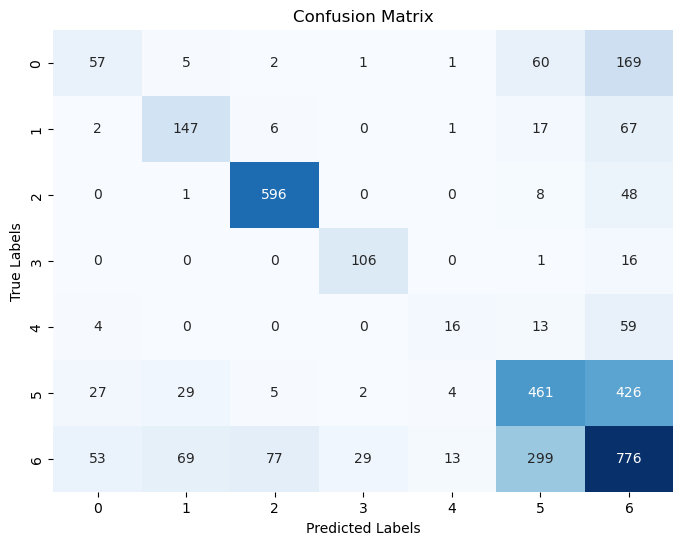

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [46]:
test = pd.read_csv("../Data/test.csv")

testid = test["id"]

test['TypeOfSteel'] = test.apply(lambda row: 0 if row['TypeOfSteel_A300'] == 1 else (1 if row['TypeOfSteel_A400'] == 1 else None), axis=1)
test = test.drop(["TypeOfSteel_A300", "TypeOfSteel_A400"], axis = 1)

test["TypeOfSteel"] = test["TypeOfSteel"].fillna(1)
testX = test.drop("id", axis = 1)

ValueError: Found input variables with inconsistent numbers of samples: [14688, 3673]

In [30]:
y_score = model.predict_proba(X_train)
y_score

array([[5.38049545e-03, 4.39359399e-04, 1.78711380e-05, ...,
        1.18355092e-03, 7.60770291e-02, 9.16897416e-01],
       [1.15362585e-04, 1.85827696e-04, 6.13556318e-02, ...,
        2.63721275e-04, 5.26335090e-03, 9.32787120e-01],
       [6.18394651e-02, 1.26343555e-04, 1.14990398e-04, ...,
        2.57034274e-03, 1.25473872e-01, 8.09845984e-01],
       ...,
       [4.94881533e-05, 8.35520208e-01, 3.10339674e-05, ...,
        1.25580584e-04, 1.61247123e-02, 1.48136079e-01],
       [1.53561890e-01, 1.59368590e-02, 4.98007284e-04, ...,
        8.87700450e-03, 1.56231642e-01, 6.64672494e-01],
       [4.15001297e-03, 2.76775303e-04, 5.01843278e-05, ...,
        2.34571449e-03, 7.70859599e-01, 2.22309008e-01]], dtype=float32)